# Modeling Volumes and Multiple Compartments 

This notebook example provides a basic demonstration on how to create and dynamically simulate multi-compartment models. 

Illustrated below is the multi-compartment model utilized in this notebook:

![MultiCompartment](../media/images/multicompartment.png)

In the above example:
* For metabolite **x**:
    * The biochemical pathway for the conversion of **x** occurs in the `large` compartment outlined by the <font color='black'> <strong>dotted black line</strong></font>.
* For metabolite **y**:
    * Cofactor **y** is necessary for the conversion of metabolite **x** in the biochemical pathway.
    * The synthesis of **y** occurs in the `medium` compartment outlined by the <font color='#44bcd8'><strong>blue line</strong></font>.
    * `R_Ytr` is an antiporter, coupling the import of **y2** into the `large` compartment with the export of **y3** to the `medium` compartment.
* For metabolite **z**:
    * Protein **z** is synthesized in the `small` compartment outlined by the <font color='red'><strong>red line</strong></font>.
    * Protein **z** is also to facilitate the conversion of **x5** back into **x4** and for metabolic functions outside of the model's scope.

The reaction converting **x5** back to **x4** converted into **x5** The pair of irreversible reactions `R3_X` and `R_XZ` form a cycle that is used to  The synthesis and degradation of metabolite **y** occurs in the **medium compartment** outlined in blue.


<div class="alert alert-warning"> 

COBRApy is currently in the process of developing improved compartment handling. These changes are outlined in the following COBRApy issues:

* https://github.com/opencobra/cobrapy/pull/725
* https://github.com/opencobra/cobrapy/projects/5

MASSpy is awaiting these COBRApy changes in order to improve how compartments are handled in dynamic simulations, SBML compatibity, etc. Once these changes have been implemented in COBRApy, a new version of MASSpy will be developed and released with improved functionality around compartments and their handling.

</div>

## Models with Multiple Compartments

In [1]:
import sympy as sym

from mass import (
    MassConfiguration, MassMetabolite, MassModel, MassReaction, Simulation)
from mass.example_data import create_example_model
from mass.visualization import plot_time_profile
model = create_example_model("MultiCompartment")

Set parameter Username


### Viewing compartments in a model
The `MassModel.compartments` attribute is used to get `dict` with compartment identifiers and their corresponding names.

In [2]:
model.compartments

{'l': 'Large', 'm': 'Medium', 's': 'Small'}

The names for the compartments can be reset or changed by using the `MassModel.compartments` attribute setter method. To reset compartment names, pass an empty dict:

In [3]:
model.compartments = {}

To set a new name for a compartment, set a `dict` using the `MassModel.compartments` method with the compartment identifer as the key and the compartment name as the value. Compartments can be set one at a time, or multiple at once:

In [4]:
model.compartments = {"l": "the large compartment"}
print(model.compartments)

model.compartments = {"m": "the medium compartment", "s": "the small compartment"}
print(model.compartments)

{'l': 'the large compartment', 'm': '', 's': ''}
{'l': 'the large compartment', 'm': 'the medium compartment', 's': 'the small compartment'}


#### Volume units

To get a list of all UnitDefinition(s) that contain a volume base unit, an modified filter that scans the base units can be applied:

In [5]:
def volumes_filter(udef):
    if list(filter(lambda u: u.kind in ["liter","litre"], udef.list_of_units)):
        return True
    return False
print(model.units.query(volumes_filter))

[<UnitDefinition Milliliters "mL" at 0x7fd600f0c190>, <UnitDefinition Concentration "mol_per_mL" at 0x7fd600f0c2b0>]


### Enabling compartment volumes in rate laws
By default, the ``MassConfiguration.exclude_compartment_volumes_in_rates`` is set as ``True``.

In [6]:
mass_config = MassConfiguration()
print(mass_config.exclude_compartment_volumes_in_rates)

True


Therefore, all automatically generated mass action rate laws do not include the compartment volume:

In [7]:
print(model.reactions.get_by_id("R2_X").rate)

kf_R2_X*x3_l(t)


To enable compartment volumes in rate laws, the ``MassConfiguration.exclude_compartment_volumes_in_rates`` attribute must be set to ``False``.

In [8]:
mass_config.exclude_compartment_volumes_in_rates = False
print(model.reactions.get_by_id("R2_X").rate)

kf_R2_X*volume_l*x3_l(t)


As seen above, volume parameters are added into the rate laws to represent compartment volumes. The volume parameters
have identifiers of format `volume_CID` , with `CID` referring to the compartment identifier (e.g., "l" for large compartment). 
For a reaction that crosses compartments, more than one "volume" parameter will appear as a variable in the rate: 

In [9]:
for param in model.reactions.get_by_id("R_Ytr").rate.atoms(sym.Symbol):
    if str(param).find("volume") != -1:
        print(param)

volume_l
volume_m



See the section on [Excluding compartments from rates](../tutorials/global_configuration.ipynb#excluding-compartments-from-rates) in the [Global Configuration](../tutorials/global_configuration.ipynb) tutorial for more information about the ``exclude_compartment_volumes_in_rates`` attribute.

### The "boundary" compartment

In boundary reactions (e.g., pseudeoreactions such as sinks, demands, and exchanges), metabolites that exist in the `boundary` a.k,a. the boundary conditions, are given a default "boundary" compartment with the identifier "b". This compartment is treated as a pseudo-compartment, and therefore the 'boundary' metabolites are treated as pseudo-metabolites, meaning no corresponding object is created for them. 

Boundary metabolites can be accessed either through the `MassReaction.boundary_metabolite` method.

In [10]:
x1_b = model.reactions.get_by_id("SK_x1_l").boundary_metabolite
x1_b

'x1_b'

If a reaction is not a boundary reaction (i.e., `MassReaction.boundary==False`) then `None` will be returned:

In [11]:
print(model.reactions.get_by_id("R_Ytr").boundary_metabolite)

None


The `boundary_metabolite` attribute is useful for getting and setting values in the `MassModel.boundary_conditions` attribute.

In [12]:
model.boundary_conditions[x1_b] = 2
model.boundary_conditions

{'x1_b': 2}

To change the 'boundary' compartment identifier and name, a `dict` is passed to the `MassConfiguration.boundary_compartment` attribute setter:

In [13]:
print("Before: {0}\n{1}".format(mass_config.boundary_compartment, model.boundary_metabolites))
mass_config.boundary_compartment = {"xt": "External compartment"}
print("\nAfter: {0}\n{1}".format(mass_config.boundary_compartment, model.boundary_metabolites))

Before: {'b': 'boundary'}
['x1_b', 'x5_b', 'y1_b', 'y4_b', 'z1_b', 'z2_b']

After: {'xt': 'External compartment'}
['x1_xt', 'x5_xt', 'y1_xt', 'y4_xt', 'z1_xt', 'z2_xt']


The "boundary" compartment is automatically assumed to have a volume of 1, and therefore is not factored in the rate laws. It is also ignored by the `MassModel.compartments` attribute, even when explicitly set:

In [14]:
for r in model.sinks:
    print("{0}: {1}".format(r.id, r.get_mass_action_rate()))
model.compartments = {"xt": "External compartment"}
model.compartments

SK_y1_m: kf_SK_y1_m*y1_xt
SK_z1_s: kf_SK_z1_s*z1_xt


{'l': 'the large compartment',
 'm': 'the medium compartment',
 's': 'the small compartment'}

See the section on [For compartments and SBML](../tutorials/global_configuration.ipynb#for-compartments-and-SBML) in the [Global Configuration](../tutorials/global_configuration.ipynb) tutorial for more information about the ``boundary_compartment`` attribute.

<div class="alert alert-info"> 

The 'boundary' pseudo-compartment and 'boundary' pseudo-metabolites are designed to make working with boundary conditions convenient at the cost of having finer user control. This primarily useful for 
* Setting functions as boundary conditions (e.g., an oscillating function for external oxygen concentration)
* Using custom rates to set fixed inputs, causing irrelevant boundary conditions to be ignored altogether.

However, for finer control over external compartment and boundary conditions (and general best practices for SBML compatibility in MASSpy), it is recommended to (1) create new `MassMetabolite` objects, define their `compartment` and `initial_condition` attributes, (2) set the  `fixed` attribute as `True`, and (3) add the metabolites to the appropriate reactions. This ensures the concentration of the metabolite is fixed at a constant value, and that its initial condition value is treated as a boundary condition. 

</div>

#### Fixed inputs
To bypass using the 'boundary' pseudo-compartment, it is recommended to set a fixed input using a custom rate law:

In [15]:
for r in model.reactions.get_by_any(["SK_x1_l", "SK_y1_m", "SK_z1_s"]):
    model.add_custom_rate(r, custom_rate=r.kf_str)
    print("{0}: {1}".format(r.id, r.rate))

SK_x1_l: kf_SK_x1_l
SK_y1_m: kf_SK_y1_m
SK_z1_s: kf_SK_z1_s


## Getting and setting compartment volumes
Support for compartment volumes is currently through the `MassModel.custom_parameters` attribute. To view what compartment volumes are set:

In [16]:
def volume_filter(parameter):
    if str(parameter).startswith("volume"):
        return True
    return False

for vol_id in filter(volume_filter, model.custom_parameters):
    print("{0}: {1}".format(vol_id, model.custom_parameters[vol_id]))

volume_l: 10.0
volume_m: 5.0
volume_s: 1.0


To set or change a compartment volume, the value in the `MassModel.custom_parameters` dict is set using the volume parameter ID as the key:

In [17]:
# Set the large compartment volume to 15 
model.custom_parameters["volume_l"] = 15

# Double current medium compartment volume
model.custom_parameters["volume_m"] = model.custom_parameters["volume_m"] * 2

# 10% decrease to current small compartment volume
model.custom_parameters["volume_s"] = model.custom_parameters["volume_s"] * (1 + (-10/100))

for vol_id in filter(volume_filter, model.custom_parameters):
    print("{0}: {1}".format(vol_id, model.custom_parameters[vol_id]))

volume_l: 15
volume_m: 10.0
volume_s: 0.9


## Simulating with Volumes and Multiple Compartments
Using a newly loaded model, the following section provides guidance on dynamic simulations for models with multiple compartments and includes examples on perturbing compartment volume.

In [18]:
# Ensure compartments are active and boundary compartment is reset
mass_config.exclude_compartment_volumes_in_rates = False
mass_config.boundary_compartment = {'b': 'boundary'}

# Start with a fresh model, checking to ensure compartment volumes are reset
model = create_example_model("MultiCompartment")
for vol_id in filter(volume_filter, model.custom_parameters):
    print("{0}: {1}".format(vol_id, model.custom_parameters[vol_id]))

volume_l: 10.0
volume_m: 5.0
volume_s: 1.0


As always, a model must first must be loaded into the `mass.Simulation`. object in order to run a simulation. A quick simulation shows that the model is already at a steady state:

Successfully loaded MassModel 'MultiCompartment' into RoadRunner.


<AxesSubplot: >

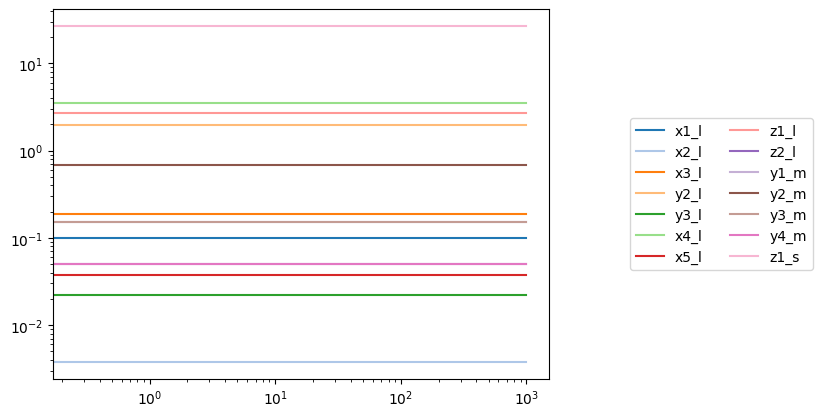

In [19]:
simulation = Simulation(model, verbose=True)
conc_sol = simulation.simulate(model, time=(0, 1000))[0]
plot_time_profile(conc_sol, plot_function="loglog", legend="right outside")

A volume parameter can be perturbed just like any other parameter using a `dict`. For example, suppose volume of the large compartment `volume_m` lost 40% of its volume:

<AxesSubplot: >

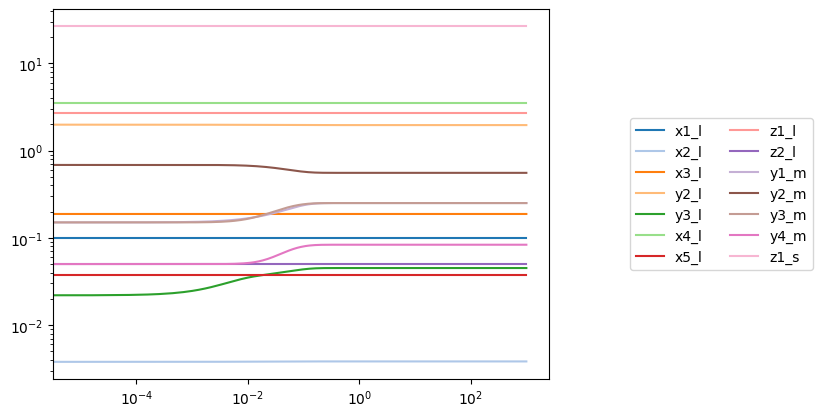

In [20]:
conc_sol = simulation.simulate(model, time=(0, 1000), perturbations={
    "volume_m": "volume_m * (1 - 0.4)",
})[0]
plot_time_profile(conc_sol, plot_function="loglog", legend="right outside")

Note that in the above simulation, several of the metabolite concentrations in the large compartment changed. The `observable` argument can be used with the `MassMetabolite.compartment` attribute to look at metabolites in a specific compartment for futher examination

<AxesSubplot: >

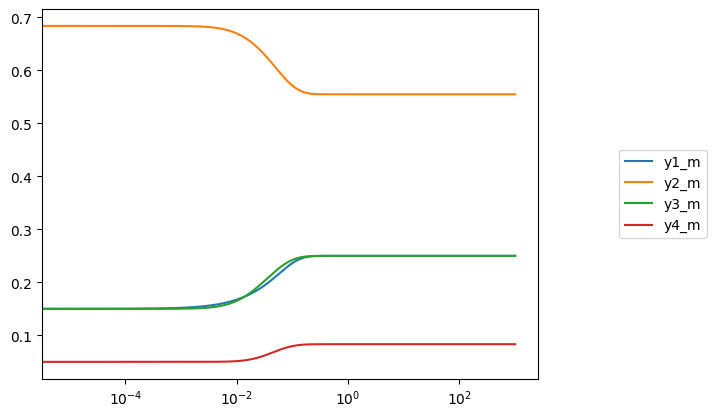

In [21]:
plot_time_profile(conc_sol, observable=list(model.metabolites.query(lambda m: m.compartment == "m")),
                  plot_function="semilogx", legend="right outside")

Multiple volumes also can be perturbed simultaneously. For example, suppose 1 mL of fluid from the `large` compartment was transfered to the `small` compartment, while 1.5 mL was transfered to the `medium` compartment:

<AxesSubplot: >

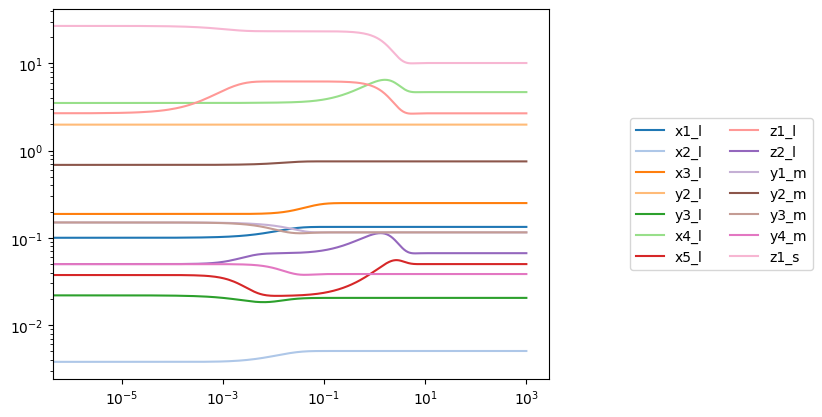

In [22]:
conc_sol = simulation.simulate(model, time=(0, 1000), perturbations={
    "volume_l": "volume_l - 2.5",
    "volume_m": "volume_m + 1.5",
    "volume_s": "volume_s + 1.0"
})[0]
plot_time_profile(conc_sol, plot_function="loglog", legend="right outside")

<div class="alert alert-info">
<strong>Helpful tips</strong>: When enabling compartment volumes, it is up to the user to track their units to ensure that no numerical consistency issues arise. To make this a bit easier, be aware of the following MASSpy expectations and behaviors:
    
* When <strong><i>compartment volumes are disabled</i></strong>, MASSpy expects that volumes are already factored into initial condition values, and therefore considers values to be <i>initial concentrations</i>. Consequently, metabolite solutions returned by solutions will be for metabolite <strong><i>concentrations</strong></i> (e.g., mol/L, g/cDW)

* When <strong><i>compartment volumes are enabled</i></strong>, MASSpy expects that volumes have not been factored factored into initial condition values, and therefore considers values to be <i>initial amounts</i>.
    Consequently, metabolite solutions returned by solutions will be for metabolite <strong><i>amounts</strong></i> (e.g., mol, grams)

</div>